# Sistema de Recomendação de Cartões de Crédito

Este notebook tem como objetivo:

1. Desenvolver um modelo preditivo para classificação do principal cartão para clientes  
2. Aplicar o modelo de clientes na base prospects  
3. Gerar arquivo final com cartão ideal (recomendação) para prospects

## Importar bibliotecas necessárias

In [2]:
# EDA e Visualização de Dados
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway
from colorama import Fore, Back, Style

# Configurar formato de exibição para não usar notação científica
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True, precision=5)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from catboost import CatBoostClassifier, Pool, cv

# Otimização
import optuna

# Utilitários
import joblib
import math

### Abrir Base Clientes

In [3]:
df_clientes = pd.read_csv('./datasets/clientes.csv')

In [4]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_Cliente                   1000 non-null   object 
 1   Nome                         1000 non-null   object 
 2   Idade                        1000 non-null   int64  
 3   Viagens                      1000 non-null   int64  
 4   Restaurantes                 1000 non-null   int64  
 5   Entretenimento               1000 non-null   int64  
 6   Cashback                     1000 non-null   int64  
 7   Compras online               1000 non-null   int64  
 8   Farmácias                    1000 non-null   int64  
 9   Programas de Milhagem        1000 non-null   int64  
 10  Postos de Combustível        1000 non-null   int64  
 11  Mercados                     1000 non-null   int64  
 12  Cidade                       1000 non-null   object 
 13  Cargo              

In [5]:
# Remover colunas únicas
df_clientes.drop(columns=['ID_Cliente', 'Nome'], axis=1, inplace=True)

In [6]:
num_vars = df_clientes.select_dtypes(include=['number']).columns
cat_vars = df_clientes.select_dtypes(include=['object']).columns
target = 'Principal Cartão'

### Testes de Hipóteses

In [7]:
# Testes de hipóteses entre Target Categórica e Numéricas (ANOVA)
for num_col in num_vars:
    groups = [df_clientes[df_clientes[target] == val][num_col] for val in df_clientes[target].unique()]
    stat, p = f_oneway(*groups)
    print(f"{Fore.RED if p < 0.05 else Fore.WHITE}"
          f"ANOVA entre {num_col} e {target}: p-valor = {p}")

ANOVA entre Idade e Principal Cartão: p-valor = 0.02334622684107804
ANOVA entre Viagens e Principal Cartão: p-valor = 4.59308651849609e-78
ANOVA entre Restaurantes e Principal Cartão: p-valor = 6.679790462858737e-13
ANOVA entre Entretenimento e Principal Cartão: p-valor = 5.089212006248722e-18
ANOVA entre Cashback e Principal Cartão: p-valor = 8.77437441029354e-12
ANOVA entre Compras online e Principal Cartão: p-valor = 0.00717148660617559
ANOVA entre Farmácias e Principal Cartão: p-valor = 0.0006390735697304401
ANOVA entre Programas de Milhagem e Principal Cartão: p-valor = 0.001269305962592174
ANOVA entre Postos de Combustível e Principal Cartão: p-valor = 0.11255638879254316
ANOVA entre Mercados e Principal Cartão: p-valor = 0.034152908342727085
ANOVA entre Tempo na Empresa e Principal Cartão: p-valor = 0.32092370365000267
ANOVA entre Pessoas em Casa e Principal Cartão: p-valor = 0.05946641455988785
ANOVA entre Renda e Principal Cartão: p-valor = 1.5360217142979344e-34
ANOVA entre I

In [8]:
# Analisando relação entre variáveis explicativas e targets
for col in num_vars:
    fig = px.box(df_clientes, x=target, y=col, title=f"{col} por {target}")
    fig.show()

for col in cat_vars:
    fig = px.histogram(df_clientes, x=col, color=target, barmode='group', title=f"{col} por {target}")
    fig.show()

### Modelo Catboost com Validação Cruzada

In [9]:
selected_features = [
    'Viagens', 'Restaurantes', 'Entretenimento', 'Cashback', 'Compras online',
    'Farmácias', 'Programas de Milhagem', 'Postos de Combustível', 'Mercados', 'Score'
]

X = df_clientes[selected_features]
y = df_clientes[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Definir os parâmetros do modelo
params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_strength': 2,
    'loss_function': 'MultiClass',  # Use 'MultiClass' para problemas de classificação multiclasse
    'eval_metric': 'MultiClass'
}

model = CatBoostClassifier(**params, random_seed=42, auto_class_weights='Balanced')

model.fit(X_train, y_train)

# Obter o log loss médio
best_score = model.best_score_['learn']['MultiClass']
print(f"LogLoss no treinamento: {best_score}")

0:	learn: 3.1361616	total: 153ms	remaining: 2m 32s
1:	learn: 3.0966905	total: 166ms	remaining: 1m 22s
2:	learn: 3.0415708	total: 177ms	remaining: 58.7s
3:	learn: 2.9918112	total: 190ms	remaining: 47.4s
4:	learn: 2.9479092	total: 201ms	remaining: 40s
5:	learn: 2.9060745	total: 212ms	remaining: 35.1s
6:	learn: 2.8958633	total: 214ms	remaining: 30.3s
7:	learn: 2.8461542	total: 225ms	remaining: 27.8s
8:	learn: 2.8098443	total: 236ms	remaining: 26s
9:	learn: 2.7748998	total: 247ms	remaining: 24.4s
10:	learn: 2.7366319	total: 258ms	remaining: 23.2s
11:	learn: 2.7120453	total: 270ms	remaining: 22.3s
12:	learn: 2.6740911	total: 281ms	remaining: 21.3s
13:	learn: 2.6420074	total: 287ms	remaining: 20.2s
14:	learn: 2.6062796	total: 298ms	remaining: 19.5s
15:	learn: 2.5769803	total: 308ms	remaining: 19s
16:	learn: 2.5486886	total: 320ms	remaining: 18.5s
17:	learn: 2.5133635	total: 331ms	remaining: 18s
18:	learn: 2.4873181	total: 342ms	remaining: 17.6s
19:	learn: 2.4615481	total: 353ms	remaining: 17

In [10]:
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)
test_loss = log_loss(y_test, probs)
print(f"LogLoss no conjunto de teste: {test_loss:.2f}")

LogLoss no conjunto de teste: 1.46


### Otimizar com Optuna

In [11]:
# Definir a função objetivo para otimização
def objective(trial):
    # Definir o espaço de busca para os hiperparâmetros
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_uniform('random_strength', 0, 10),
        'loss_function': 'MultiClass',
        'eval_metric': 'MultiClass'
    }

    model = CatBoostClassifier(**params, random_seed=42, auto_class_weights='Balanced')

    model.fit(X_train, y_train)
    best_score = model.best_score_['learn']['MultiClass']

    return best_score

# Criar um estudo e otimizar
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # Ajuste o número de trials conforme necessário

# Obter os melhores parâmetros
best_params = study.best_params
best_metric = study.best_value
print("Melhores parâmetros:", best_params)
print("Melhor métrica:", best_metric)

[I 2025-05-12 22:07:30,205] A new study created in memory with name: no-name-26a4c45c-9d11-4d71-8964-a343a1afbba0
C:\Users\guilh\AppData\Local\Temp\ipykernel_9220\408286153.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\guilh\AppData\Local\Temp\ipykernel_9220\408286153.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\guilh\AppData\Local\Temp\ipykernel_9220\408286153.py:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



0:	learn: 3.1723927	total: 21ms	remaining: 3.82s
1:	learn: 3.1668416	total: 41.6ms	remaining: 3.77s
2:	learn: 3.1613296	total: 61.5ms	remaining: 3.69s
3:	learn: 3.1559104	total: 81.1ms	remaining: 3.63s
4:	learn: 3.1508230	total: 101ms	remaining: 3.58s
5:	learn: 3.1454938	total: 120ms	remaining: 3.54s
6:	learn: 3.1389646	total: 141ms	remaining: 3.54s
7:	learn: 3.1339368	total: 162ms	remaining: 3.54s
8:	learn: 3.1293447	total: 177ms	remaining: 3.42s
9:	learn: 3.1242274	total: 201ms	remaining: 3.48s
10:	learn: 3.1232174	total: 202ms	remaining: 3.16s
11:	learn: 3.1172990	total: 223ms	remaining: 3.17s
12:	learn: 3.1120495	total: 244ms	remaining: 3.19s
13:	learn: 3.1071278	total: 267ms	remaining: 3.22s
14:	learn: 3.1012900	total: 287ms	remaining: 3.21s
15:	learn: 3.0965688	total: 312ms	remaining: 3.25s
16:	learn: 3.0917355	total: 333ms	remaining: 3.25s
17:	learn: 3.0861269	total: 356ms	remaining: 3.26s
18:	learn: 3.0799895	total: 376ms	remaining: 3.24s
19:	learn: 3.0748870	total: 396ms	remai

[I 2025-05-12 22:07:33,681] Trial 0 finished with value: 2.446650598422924 and parameters: {'iterations': 183, 'depth': 7, 'learning_rate': 0.010903479410007426, 'l2_leaf_reg': 7.718744854132106, 'random_strength': 1.311853134488623}. Best is trial 0 with value: 2.446650598422924.


174:	learn: 2.4696421	total: 3.25s	remaining: 148ms
175:	learn: 2.4665033	total: 3.27s	remaining: 130ms
176:	learn: 2.4636258	total: 3.29s	remaining: 111ms
177:	learn: 2.4607701	total: 3.31s	remaining: 92.9ms
178:	learn: 2.4573528	total: 3.33s	remaining: 74.4ms
179:	learn: 2.4544726	total: 3.35s	remaining: 55.8ms
180:	learn: 2.4526384	total: 3.36s	remaining: 37.1ms
181:	learn: 2.4495863	total: 3.38s	remaining: 18.5ms
182:	learn: 2.4466506	total: 3.4s	remaining: 0us
0:	learn: 3.1707683	total: 4.75ms	remaining: 494ms
1:	learn: 3.1629903	total: 8.13ms	remaining: 419ms
2:	learn: 3.1607434	total: 9.5ms	remaining: 323ms
3:	learn: 3.1498168	total: 12.8ms	remaining: 323ms
4:	learn: 3.1391130	total: 16.4ms	remaining: 328ms
5:	learn: 3.1271901	total: 19.9ms	remaining: 328ms
6:	learn: 3.1203095	total: 23.1ms	remaining: 323ms
7:	learn: 3.1133632	total: 26.1ms	remaining: 316ms
8:	learn: 3.1014916	total: 29.6ms	remaining: 316ms
9:	learn: 3.0937261	total: 33.3ms	remaining: 316ms
10:	learn: 3.0858726	

[I 2025-05-12 22:07:34,081] Trial 1 finished with value: 2.468303141474934 and parameters: {'iterations': 105, 'depth': 4, 'learning_rate': 0.011394180623578875, 'l2_leaf_reg': 2.808323603451099, 'random_strength': 7.541124032416312}. Best is trial 0 with value: 2.446650598422924.


64:	learn: 2.7024888	total: 220ms	remaining: 135ms
65:	learn: 2.6958256	total: 223ms	remaining: 132ms
66:	learn: 2.6877745	total: 226ms	remaining: 128ms
67:	learn: 2.6817169	total: 230ms	remaining: 125ms
68:	learn: 2.6734741	total: 233ms	remaining: 121ms
69:	learn: 2.6688429	total: 236ms	remaining: 118ms
70:	learn: 2.6633954	total: 239ms	remaining: 115ms
71:	learn: 2.6571228	total: 243ms	remaining: 111ms
72:	learn: 2.6518109	total: 246ms	remaining: 108ms
73:	learn: 2.6480820	total: 249ms	remaining: 104ms
74:	learn: 2.6405216	total: 252ms	remaining: 101ms
75:	learn: 2.6345683	total: 255ms	remaining: 97.4ms
76:	learn: 2.6262136	total: 258ms	remaining: 94ms
77:	learn: 2.6215786	total: 261ms	remaining: 90.5ms
78:	learn: 2.6168098	total: 265ms	remaining: 87.1ms
79:	learn: 2.6100089	total: 267ms	remaining: 83.5ms
80:	learn: 2.6044399	total: 270ms	remaining: 80.1ms
81:	learn: 2.5975940	total: 273ms	remaining: 76.7ms
82:	learn: 2.5925572	total: 276ms	remaining: 73.3ms
83:	learn: 2.5847003	tota

[I 2025-05-12 22:07:37,316] Trial 2 finished with value: 0.8871705557225606 and parameters: {'iterations': 175, 'depth': 7, 'learning_rate': 0.021122867620536563, 'l2_leaf_reg': 1.0196750763802624, 'random_strength': 3.7445906518312877}. Best is trial 2 with value: 0.8871705557225606.


167:	learn: 0.9230734	total: 3.06s	remaining: 127ms
168:	learn: 0.9169166	total: 3.08s	remaining: 109ms
169:	learn: 0.9116592	total: 3.08s	remaining: 90.6ms
170:	learn: 0.9059260	total: 3.1s	remaining: 72.5ms
171:	learn: 0.9013317	total: 3.12s	remaining: 54.4ms
172:	learn: 0.8966538	total: 3.14s	remaining: 36.3ms
173:	learn: 0.8908445	total: 3.14s	remaining: 18.1ms
174:	learn: 0.8871706	total: 3.16s	remaining: 0us
0:	learn: 3.1616347	total: 12ms	remaining: 9.8s
1:	learn: 3.1542955	total: 15.5ms	remaining: 6.29s
2:	learn: 3.1388662	total: 26.1ms	remaining: 7.08s
3:	learn: 3.1171161	total: 38ms	remaining: 7.71s
4:	learn: 3.1095703	total: 41.4ms	remaining: 6.71s
5:	learn: 3.0926434	total: 52.3ms	remaining: 7.06s
6:	learn: 3.0787400	total: 63.2ms	remaining: 7.3s
7:	learn: 3.0615979	total: 73.7ms	remaining: 7.45s
8:	learn: 3.0444181	total: 84.6ms	remaining: 7.58s
9:	learn: 3.0315097	total: 95.4ms	remaining: 7.69s
10:	learn: 3.0160538	total: 107ms	remaining: 7.81s
11:	learn: 2.9994865	total:

[I 2025-05-12 22:07:46,278] Trial 3 finished with value: 0.3468706003864735 and parameters: {'iterations': 816, 'depth': 6, 'learning_rate': 0.01504427332724419, 'l2_leaf_reg': 2.0043639097610333, 'random_strength': 9.157030907387544}. Best is trial 3 with value: 0.3468706003864735.


810:	learn: 0.3495624	total: 8.68s	remaining: 53.5ms
811:	learn: 0.3488515	total: 8.7s	remaining: 42.8ms
812:	learn: 0.3483717	total: 8.71s	remaining: 32.1ms
813:	learn: 0.3478688	total: 8.72s	remaining: 21.4ms
814:	learn: 0.3473822	total: 8.73s	remaining: 10.7ms
815:	learn: 0.3468706	total: 8.74s	remaining: 0us
0:	learn: 3.1608546	total: 4.23ms	remaining: 596ms
1:	learn: 3.1358758	total: 8.53ms	remaining: 597ms
2:	learn: 3.0986747	total: 13.3ms	remaining: 615ms
3:	learn: 3.0705050	total: 16.9ms	remaining: 584ms
4:	learn: 3.0419244	total: 20.1ms	remaining: 550ms
5:	learn: 3.0146939	total: 23.5ms	remaining: 533ms
6:	learn: 2.9984651	total: 27.1ms	remaining: 522ms
7:	learn: 2.9774206	total: 29.8ms	remaining: 498ms
8:	learn: 2.9594330	total: 33ms	remaining: 487ms
9:	learn: 2.9417539	total: 35.9ms	remaining: 474ms
10:	learn: 2.9171847	total: 38.8ms	remaining: 462ms
11:	learn: 2.8955736	total: 41.9ms	remaining: 454ms
12:	learn: 2.8812524	total: 44.9ms	remaining: 445ms
13:	learn: 2.8678182	t

[I 2025-05-12 22:07:46,775] Trial 4 finished with value: 1.5731825452721555 and parameters: {'iterations': 142, 'depth': 4, 'learning_rate': 0.020306603589425085, 'l2_leaf_reg': 1.5895994259259036, 'random_strength': 1.9090272821804577}. Best is trial 3 with value: 0.3468706003864735.


86:	learn: 1.9617475	total: 276ms	remaining: 174ms
87:	learn: 1.9553497	total: 279ms	remaining: 171ms
88:	learn: 1.9466053	total: 283ms	remaining: 168ms
89:	learn: 1.9406649	total: 286ms	remaining: 165ms
90:	learn: 1.9332797	total: 288ms	remaining: 162ms
91:	learn: 1.9263262	total: 291ms	remaining: 158ms
92:	learn: 1.9169207	total: 294ms	remaining: 155ms
93:	learn: 1.9081471	total: 298ms	remaining: 152ms
94:	learn: 1.8976320	total: 301ms	remaining: 149ms
95:	learn: 1.8906398	total: 304ms	remaining: 146ms
96:	learn: 1.8871447	total: 306ms	remaining: 142ms
97:	learn: 1.8797745	total: 310ms	remaining: 139ms
98:	learn: 1.8727383	total: 313ms	remaining: 136ms
99:	learn: 1.8604666	total: 315ms	remaining: 132ms
100:	learn: 1.8545265	total: 318ms	remaining: 129ms
101:	learn: 1.8473482	total: 321ms	remaining: 126ms
102:	learn: 1.8362657	total: 324ms	remaining: 123ms
103:	learn: 1.8290337	total: 327ms	remaining: 120ms
104:	learn: 1.8222967	total: 331ms	remaining: 116ms
105:	learn: 1.8147706	tota

[I 2025-05-12 22:08:12,998] Trial 5 finished with value: 1.2310755377412534 and parameters: {'iterations': 686, 'depth': 8, 'learning_rate': 0.01317435814241921, 'l2_leaf_reg': 8.816349775467273, 'random_strength': 0.5706453747388129}. Best is trial 3 with value: 0.3468706003864735.


685:	learn: 1.2310755	total: 26s	remaining: 0us
0:	learn: 3.1247421	total: 150ms	remaining: 1m 19s
1:	learn: 3.0700720	total: 302ms	remaining: 1m 19s
2:	learn: 3.0248351	total: 314ms	remaining: 55.1s
3:	learn: 2.9807640	total: 335ms	remaining: 44s
4:	learn: 2.9408699	total: 341ms	remaining: 35.8s
5:	learn: 2.8934430	total: 491ms	remaining: 42.9s
6:	learn: 2.8529187	total: 566ms	remaining: 42.3s
7:	learn: 2.8140001	total: 572ms	remaining: 37.4s
8:	learn: 2.7734043	total: 721ms	remaining: 41.7s
9:	learn: 2.7244363	total: 762ms	remaining: 39.6s
10:	learn: 2.6830819	total: 911ms	remaining: 43s
11:	learn: 2.6517869	total: 931ms	remaining: 40.2s
12:	learn: 2.6275561	total: 935ms	remaining: 37.2s
13:	learn: 2.5948673	total: 1.08s	remaining: 40s
14:	learn: 2.5623742	total: 1.12s	remaining: 38.6s
15:	learn: 2.5258021	total: 1.2s	remaining: 38.6s
16:	learn: 2.4867584	total: 1.28s	remaining: 38.5s
17:	learn: 2.4556941	total: 1.42s	remaining: 40.5s
18:	learn: 2.4257587	total: 1.58s	remaining: 42.4

[I 2025-05-12 22:09:28,292] Trial 6 finished with value: 0.17774095367651896 and parameters: {'iterations': 530, 'depth': 10, 'learning_rate': 0.07208780834860004, 'l2_leaf_reg': 4.604566649172874, 'random_strength': 3.9619108058253314}. Best is trial 6 with value: 0.17774095367651896.


0:	learn: 3.1515232	total: 51.5ms	remaining: 27.4s
1:	learn: 3.1250418	total: 92.2ms	remaining: 24.5s
2:	learn: 3.0972917	total: 138ms	remaining: 24.4s
3:	learn: 3.0941873	total: 140ms	remaining: 18.5s
4:	learn: 3.0698190	total: 179ms	remaining: 18.9s
5:	learn: 3.0621288	total: 184ms	remaining: 16.2s
6:	learn: 3.0387901	total: 232ms	remaining: 17.4s
7:	learn: 3.0151282	total: 276ms	remaining: 18.1s
8:	learn: 2.9929245	total: 320ms	remaining: 18.6s
9:	learn: 2.9726846	total: 360ms	remaining: 18.8s
10:	learn: 2.9471776	total: 398ms	remaining: 18.9s
11:	learn: 2.9261007	total: 441ms	remaining: 19.1s
12:	learn: 2.9142418	total: 444ms	remaining: 17.8s
13:	learn: 2.8975942	total: 464ms	remaining: 17.2s
14:	learn: 2.8869335	total: 467ms	remaining: 16.1s
15:	learn: 2.8688373	total: 508ms	remaining: 16.4s
16:	learn: 2.8505715	total: 545ms	remaining: 16.5s
17:	learn: 2.8446154	total: 551ms	remaining: 15.8s
18:	learn: 2.8278142	total: 574ms	remaining: 15.5s
19:	learn: 2.8114176	total: 601ms	remai

[I 2025-05-12 22:09:45,283] Trial 7 finished with value: 0.4837056488817918 and parameters: {'iterations': 533, 'depth': 8, 'learning_rate': 0.01594073624037705, 'l2_leaf_reg': 1.6228225897255542, 'random_strength': 9.173525975969083}. Best is trial 6 with value: 0.17774095367651896.


0:	learn: 3.0892808	total: 99.7ms	remaining: 1m 32s
1:	learn: 3.0092477	total: 191ms	remaining: 1m 27s
2:	learn: 2.9336743	total: 296ms	remaining: 1m 30s
3:	learn: 2.8597236	total: 387ms	remaining: 1m 29s
4:	learn: 2.8015291	total: 474ms	remaining: 1m 27s
5:	learn: 2.7411601	total: 573ms	remaining: 1m 27s
6:	learn: 2.6788735	total: 668ms	remaining: 1m 27s
7:	learn: 2.6174132	total: 752ms	remaining: 1m 26s
8:	learn: 2.5538127	total: 835ms	remaining: 1m 24s
9:	learn: 2.5031328	total: 914ms	remaining: 1m 23s
10:	learn: 2.4551522	total: 996ms	remaining: 1m 22s
11:	learn: 2.4077108	total: 1.08s	remaining: 1m 22s
12:	learn: 2.3607303	total: 1.16s	remaining: 1m 21s
13:	learn: 2.3149521	total: 1.25s	remaining: 1m 21s
14:	learn: 2.2728515	total: 1.33s	remaining: 1m 20s
15:	learn: 2.2329240	total: 1.41s	remaining: 1m 20s
16:	learn: 2.1942622	total: 1.51s	remaining: 1m 20s
17:	learn: 2.1574463	total: 1.6s	remaining: 1m 20s
18:	learn: 2.1184659	total: 1.7s	remaining: 1m 20s
19:	learn: 2.0782517	to

[I 2025-05-12 22:10:58,212] Trial 8 finished with value: 0.04175439017428886 and parameters: {'iterations': 924, 'depth': 9, 'learning_rate': 0.03306665767872676, 'l2_leaf_reg': 1.0177296926570445, 'random_strength': 0.300852992335392}. Best is trial 8 with value: 0.04175439017428886.


0:	learn: 3.1660983	total: 6.91ms	remaining: 5.05s
1:	learn: 3.1528681	total: 13.6ms	remaining: 4.95s
2:	learn: 3.1421985	total: 19.9ms	remaining: 4.84s
3:	learn: 3.1272450	total: 27.3ms	remaining: 4.97s
4:	learn: 3.1172234	total: 33.9ms	remaining: 4.92s
5:	learn: 3.1092880	total: 40.6ms	remaining: 4.92s
6:	learn: 3.0965911	total: 47ms	remaining: 4.86s
7:	learn: 3.0849858	total: 54.6ms	remaining: 4.94s
8:	learn: 3.0683539	total: 60.7ms	remaining: 4.87s
9:	learn: 3.0578755	total: 68.1ms	remaining: 4.91s
10:	learn: 3.0470999	total: 74.8ms	remaining: 4.9s
11:	learn: 3.0372542	total: 81.9ms	remaining: 4.91s
12:	learn: 3.0284304	total: 87.6ms	remaining: 4.85s
13:	learn: 3.0154486	total: 93.5ms	remaining: 4.79s
14:	learn: 3.0021855	total: 99.2ms	remaining: 4.74s
15:	learn: 2.9921526	total: 105ms	remaining: 4.71s
16:	learn: 2.9839119	total: 111ms	remaining: 4.67s
17:	learn: 2.9738119	total: 116ms	remaining: 4.61s
18:	learn: 2.9659384	total: 122ms	remaining: 4.59s
19:	learn: 2.9551130	total: 1

[I 2025-05-12 22:11:02,964] Trial 9 finished with value: 0.7967014108102051 and parameters: {'iterations': 732, 'depth': 5, 'learning_rate': 0.014324793665067741, 'l2_leaf_reg': 7.006422303855853, 'random_strength': 0.08736541677495602}. Best is trial 8 with value: 0.04175439017428886.


716:	learn: 0.8077022	total: 4.48s	remaining: 93.8ms
717:	learn: 0.8068453	total: 4.49s	remaining: 87.5ms
718:	learn: 0.8061100	total: 4.49s	remaining: 81.2ms
719:	learn: 0.8053642	total: 4.5s	remaining: 75ms
720:	learn: 0.8045961	total: 4.5s	remaining: 68.7ms
721:	learn: 0.8039226	total: 4.51s	remaining: 62.5ms
722:	learn: 0.8031313	total: 4.52s	remaining: 56.2ms
723:	learn: 0.8023253	total: 4.52s	remaining: 50ms
724:	learn: 0.8015158	total: 4.53s	remaining: 43.7ms
725:	learn: 0.8007651	total: 4.54s	remaining: 37.5ms
726:	learn: 0.8000768	total: 4.54s	remaining: 31.2ms
727:	learn: 0.7994407	total: 4.55s	remaining: 25ms
728:	learn: 0.7987878	total: 4.55s	remaining: 18.7ms
729:	learn: 0.7981004	total: 4.56s	remaining: 12.5ms
730:	learn: 0.7973753	total: 4.56s	remaining: 6.24ms
731:	learn: 0.7967014	total: 4.57s	remaining: 0us
Melhores parâmetros: {'iterations': 924, 'depth': 9, 'learning_rate': 0.03306665767872676, 'l2_leaf_reg': 1.0177296926570445, 'random_strength': 0.300852992335392}

In [12]:
# Treinar o modelo final com os parâmetros otimizados
best_model = CatBoostClassifier(**best_params,
                                verbose=False,
                                random_seed=42)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)
test_loss = log_loss(y_test, probs)

print(f"LogLoss no conjunto de teste: {test_loss:.2f}")

LogLoss no conjunto de teste: 1.62



Relatório de Classificação:
                                         precision    recall  f1-score   support

       Rocketseat Mastercard Life Basic       0.51      0.44      0.47        79
       Rocketseat Mastercard Life Elite       0.38      0.29      0.33        17
    Rocketseat Mastercard Life Platinum       0.00      0.00      0.00         1
      Rocketseat Mastercard Life Select       0.52      0.52      0.52        25
   Rocketseat Mastercard Shopping Basic       0.36      0.55      0.44        40
   Rocketseat Mastercard Shopping Elite       0.33      0.43      0.38         7
Rocketseat Mastercard Shopping Platinum       0.00      0.00      0.00         2
  Rocketseat Mastercard Shopping Select       0.29      0.36      0.32        14
     Rocketseat Mastercard Travel Basic       0.47      0.76      0.58        45
     Rocketseat Mastercard Travel Elite       0.50      0.22      0.31         9
  Rocketseat Mastercard Travel Platinum       0.00      0.00      0.00         

c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



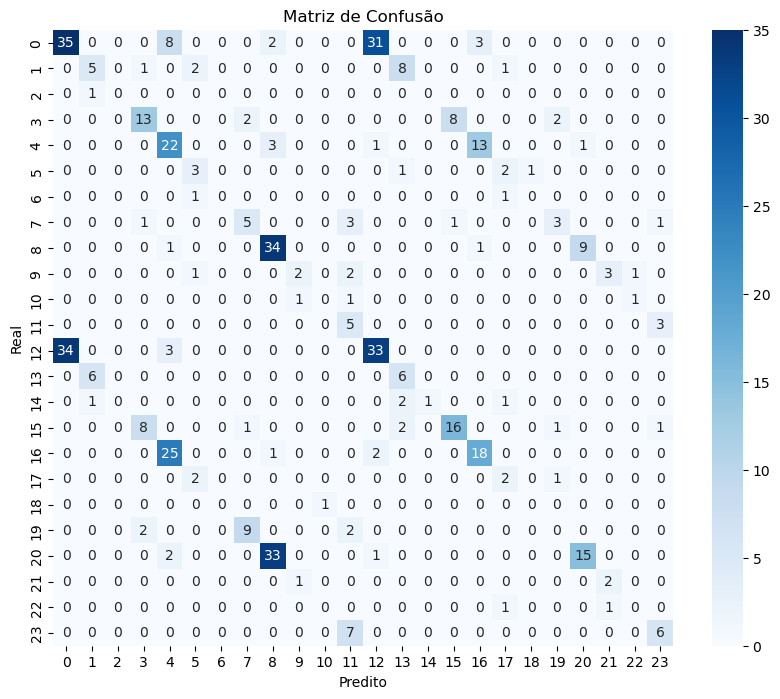

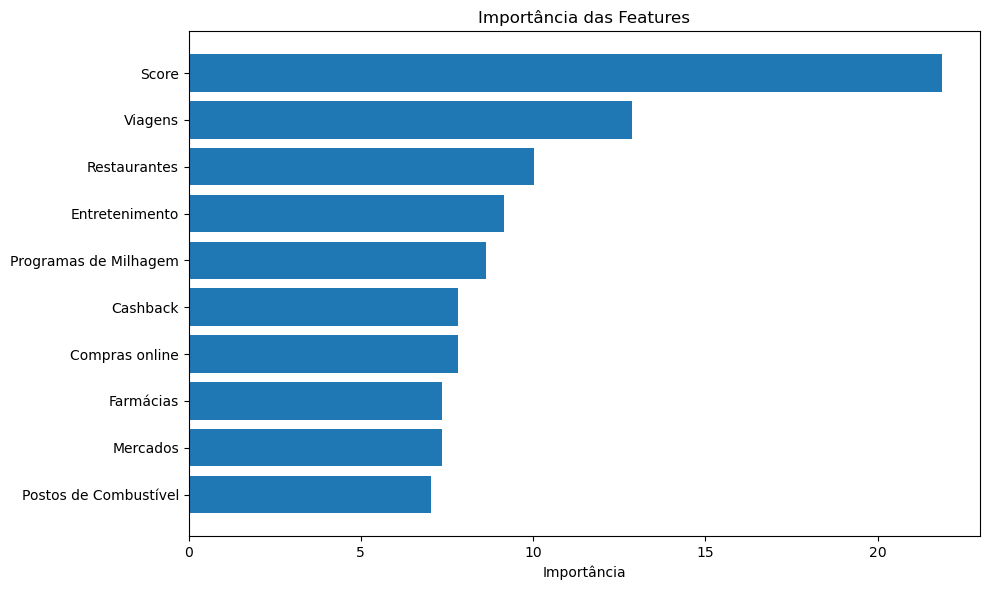

In [13]:
# Calcular e exibir métricas
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Criar matriz de confusão
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Plotar importância das features
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Importância das Features')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

# Salvar Modelo

In [14]:
joblib.dump(best_model, 'modelo_recomendacao.pkl')

['modelo_recomendacao.pkl']

### Abrir Base Prospects com Score

In [15]:
# Carregar Prospects
df_prospects = pd.read_csv('./datasets/prospects_com_score.csv')

In [16]:
df_prospects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_Prospect                  500 non-null    object 
 1   Nome                         500 non-null    object 
 2   Idade                        500 non-null    int64  
 3   Viagens                      500 non-null    int64  
 4   Restaurantes                 500 non-null    int64  
 5   Entretenimento               500 non-null    int64  
 6   Cashback                     500 non-null    int64  
 7   Compras online               500 non-null    int64  
 8   Farmácias                    500 non-null    int64  
 9   Programas de Milhagem        500 non-null    int64  
 10  Postos de Combustível        500 non-null    int64  
 11  Mercados                     500 non-null    int64  
 12  Cidade                       500 non-null    object 
 13  Cargo               

### Carregar Modelo

In [17]:
modelo = joblib.load('./modelo_recomendacao.pkl')

In [18]:
# Preparar dados
selected_features = ['Viagens', 'Restaurantes', 'Entretenimento', 'Cashback', 'Compras online', 'Farmácias',
                     'Programas de Milhagem', 'Postos de Combustível', 'Mercados', 'Score']
X_prospects = df_prospects[selected_features]

### Realizar Predição

In [19]:
# Fazer previsões
df_prospects['Principal Cartão'] = modelo.predict(X_prospects).squeeze()

### Salvar Resultados da Recomendação

In [20]:
# Salvar resultados
df_prospects.to_csv('./datasets/prospects_com_recomendacao.csv', index=False)